In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from theano import shared as tshared
import theano.tensor as tt
from theano import function, printing
import arviz as az

# Random seed
np.random.seed(713)

In [2]:
import matplotlib

%matplotlib inline

# change some plotting defaults
# plt.rc('xtick',labelsize=26)
# plt.rc('ytick',labelsize=26)
# plt.rcParams['xtick.major.size'] = 8
# plt.rcParams['xtick.major.width'] = 1.5
# plt.rcParams['xtick.minor.size'] = 5
# plt.rcParams['xtick.minor.width'] = 1.25
# plt.rcParams['ytick.major.size'] = 8
# plt.rcParams['ytick.major.width'] = 1.5
# plt.rcParams['ytick.minor.size'] = 5
# plt.rcParams['ytick.minor.width'] = 1.25
# plt.rcParams['axes.linewidth'] = 2
matplotlib.rcParams.update(
    {"font.size": 16, "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

matplotlib.rcParams['figure.dpi']= 150

# colors to use
c_flatirons = '#8B2131'
c_sunshine = '#CA9500'
c_skyline = '#1D428A'
c_midnight = '#0E2240'

colors = [c_flatirons, c_sunshine, c_skyline, c_midnight]

## Infer Emulation errors using LF and HF points


In [3]:
# (LF points, HF points, mean errors, max errors)
data = np.loadtxt("../budget_size/bugdget_size_new.txt")

The parametric model is

$$
\mathrm{error} = \theta \cdot n_\mathrm{LF}^{- \nu / d} + n_\mathrm{HF}^{- \nu / d}
$$

In [4]:
x_train = data[:, [0, 1]]
y_train = data[:, [4]] #data[:, [2]]
y_sigma = data[:, [3]]

y_max = data[:, [4]]

# dimensionality of the emulator
d = 5

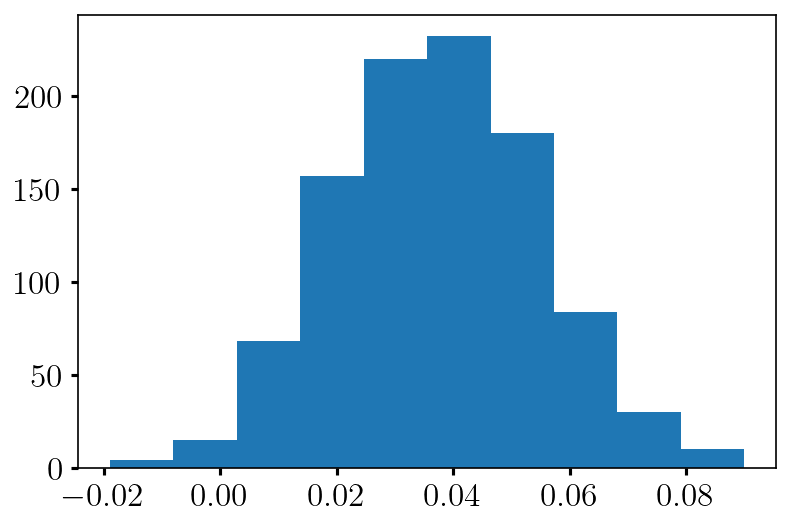

In [5]:
plt.hist(pm.Normal.dist(mu=y_train.mean(), sigma=y_train.std()).random(size=1000));

In [6]:
with pm.Model() as budget_model:
    theta = pm.Normal("theta", mu=y_train.mean(), sigma=y_train.std())

    rho   = pm.Uniform("rho", 0, 50)

    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu1 = pm.Uniform("nu1", 0, 15)
#     nu2 = pm.InverseGamma("nu2", alpha=2, beta=1)

    y = theta * ( rho * x_train[:, 0] ** (- nu1 / d) +  x_train[:, 1] ** (- nu1 / d)) 

    pm.Normal("likelihood", mu=y, sigma=y_sigma[:, 0], observed=y_train[:, 0])

In [7]:
with budget_model:
    trace = pm.sample(10000, tune=35000, )

/home/jibancat/.pyenv/versions/miniconda3-4.7.12/envs/pymc3_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu1, rho, theta]


Sampling 4 chains for 35_000 tune and 10_000 draw iterations (140_000 + 40_000 draws total) took 104 seconds.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6988431704138294, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1167 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5428206465155736, but should be close to 0.8. Try to increase the number of tuning steps.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.636617167513719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917373587409525, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective sam

In [9]:
n_lf = x_train[:, 0]
n_hf = x_train[:, 1]

y_true = y_train[:, 0]

# theta_mode = stats.mode(trace["theta"], axis=0).mode[0]
# rho_mode   = stats.mode(trace["rho"], axis=0).mode[0]
# nu_mode    = stats.mode(trace["nu1"], axis=0).mode[0]

theta_mode = np.median(trace["theta"])
rho_mode   = np.median(trace["rho"])
nu_mode    = np.median(trace["nu1"])


theta_lower, theta_mode, theta_upper = np.quantile(trace["theta"], [0.25, 0.5, 0.75])
nu_lower, nu_mode, nu_upper       = np.quantile(trace["nu1"], [0.25, 0.5, 0.75])
rho_lower, rho_mode, rho_upper       = np.quantile(trace["rho"], [0.25, 0.5, 0.75])
# theta_mode = np.mean(trace["theta"], axis=0)
# rho_mode   = np.mean(trace["rho"], axis=0)
# nu_mode    = np.mean(trace["nu1"], axis=0)

# theta_mode = np.median(pm.stats.hdi(trace["theta"], hdi_prob=0.1))
# rho_mode   = np.median(pm.stats.hdi(trace["rho"], hdi_prob=0.1))
# nu_mode    = np.median(pm.stats.hdi(trace["nu1"], hdi_prob=0.1))


y_pred = theta_mode * (
    rho_mode * n_lf ** (- nu_mode / d )
 +             n_hf ** (- nu_mode / d )
)

y_pred_lower = theta_lower * (
    rho_lower * n_lf ** (- nu_upper / d )
 +              n_hf ** (- nu_upper / d )
)

y_pred_upper = theta_upper * (
    rho_upper * n_lf ** (- nu_lower / d )
 +              n_hf ** (- nu_lower / d )
)

print(rho_mode, nu_mode, theta_mode)

0.5042090812289546 1.601613894752058 0.048446983058016466


Old data up to 9 HFs
50.87333463864485 5.667590990614169 0.00889705216141875


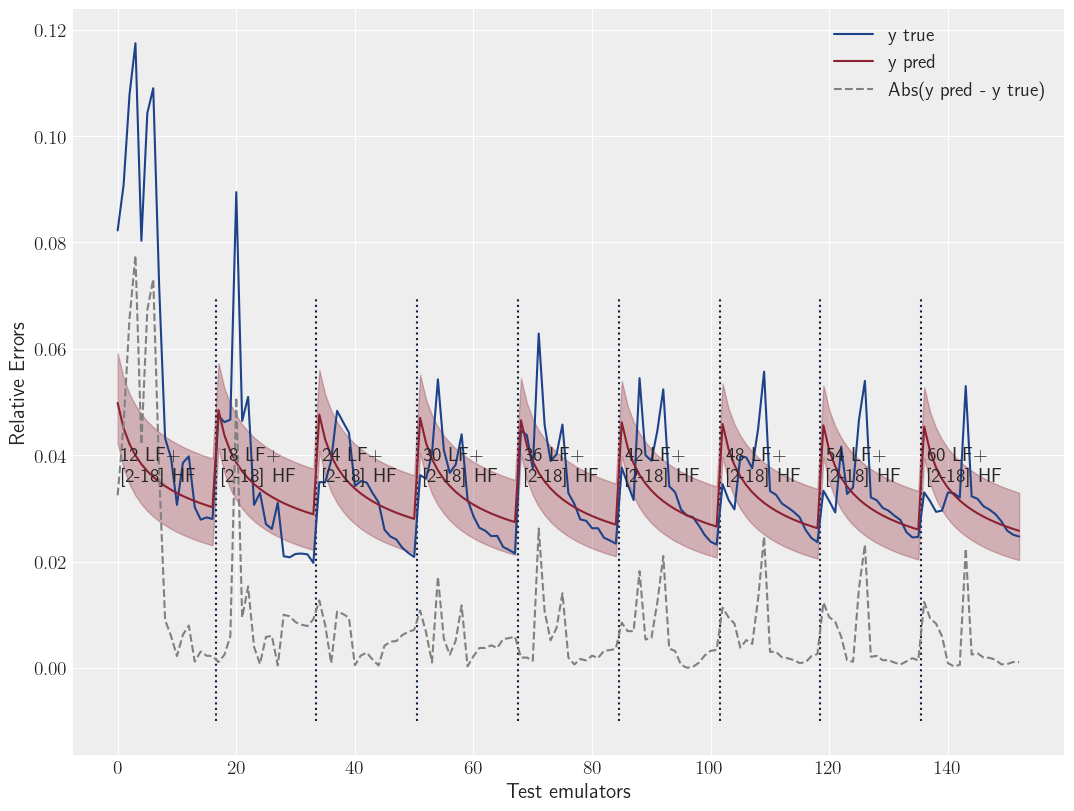

In [11]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

plt.plot(range(len(y_true)), y_true, label=r"y true", color=colors[2])
plt.plot(range(len(y_true)), y_pred, label=r"y pred", color=colors[0])

hf_size = 17
lf_size = 9

plt.vlines(
    [
        hf_size - 0.5 + hf_size * i for i in range(lf_size - 1)
    ],
    ymin=-0.01, ymax=0.07, ls="dotted", color=colors[3])

for i in range(lf_size):
    plt.text(
        0.5 + hf_size * i,
        0.035,
        "{} LF+\n[2-18] HF".format(12 + 6 * i),
        fontdict={"fontsize" : 14}
    )


plt.fill_between(range(len(y_true)), y1=y_pred_lower, y2=y_pred_upper, alpha=0.3, color=colors[0])

plt.plot(np.abs(y_pred - y_true), ls="--", color="grey", label=r"Abs(y pred - y true)" )

# plt.ylim((0.0, 0.05))
plt.ylabel("Relative Errors")
plt.xlabel("Test emulators")
plt.legend()

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_all_test_errors.pdf", bbox_inches='tight', pad_inches=0.075)


Text(0, 0.5, 'Relative Errors')

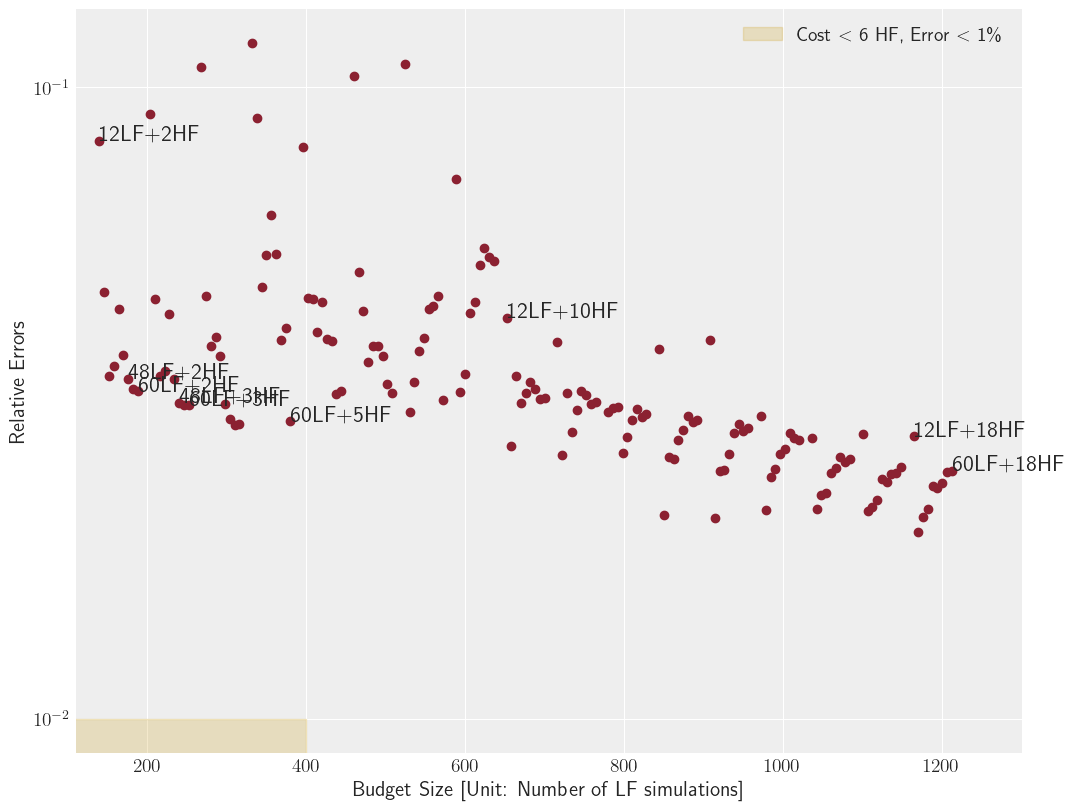

In [12]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

ax.scatter(
    n_lf + n_hf * 64, y_true,
    color=colors[0]
)

ax.set_yscale("log")

ax.fill_between(
    np.linspace(0, 400), y1=0.01, alpha=0.2, color=colors[1],
    label="Cost $<$ 6 HF, Error $<$ 1\%"
)

for i,(x,y) in enumerate(zip(n_lf + n_hf * 64, y_true)):
#     plt.text(x, y, i)    
    if i in [0, 103, 136, 137, 139, 102, 16, 8, 152]:
        plt.text(x, y, "{}LF+{}HF".format(int(n_lf[i]), int(n_hf[i])))

ax.set_xlim(110, 1300)
ax.legend()

plt.xlabel("Budget Size [Unit: Number of LF simulations]")
plt.ylabel("Relative Errors")

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_all_costs_errors.pdf", bbox_inches='tight', pad_inches=0.075)

In [13]:
np.quantile(trace["theta"], [0.25, 0.5, 0.75])

array([0.04554226, 0.04844698, 0.05137376])

In [14]:
np.quantile(trace["nu1"], [0.25, 0.5, 0.75])

array([1.45447686, 1.60161389, 1.75000671])

In [15]:
np.quantile(trace["rho"], [0.25, 0.5, 0.75])

array([0.33977525, 0.50420908, 0.69001167])

In [16]:
budget_size_fn = lambda num_lf, num_hf, theta, rho, nu : theta * (rho * num_lf ** (- nu / 5) + num_hf ** (- nu / 5)) 

In [17]:
budget_size_fn(60, 6, theta_mode, rho_mode, nu_mode)

0.033871276033979485

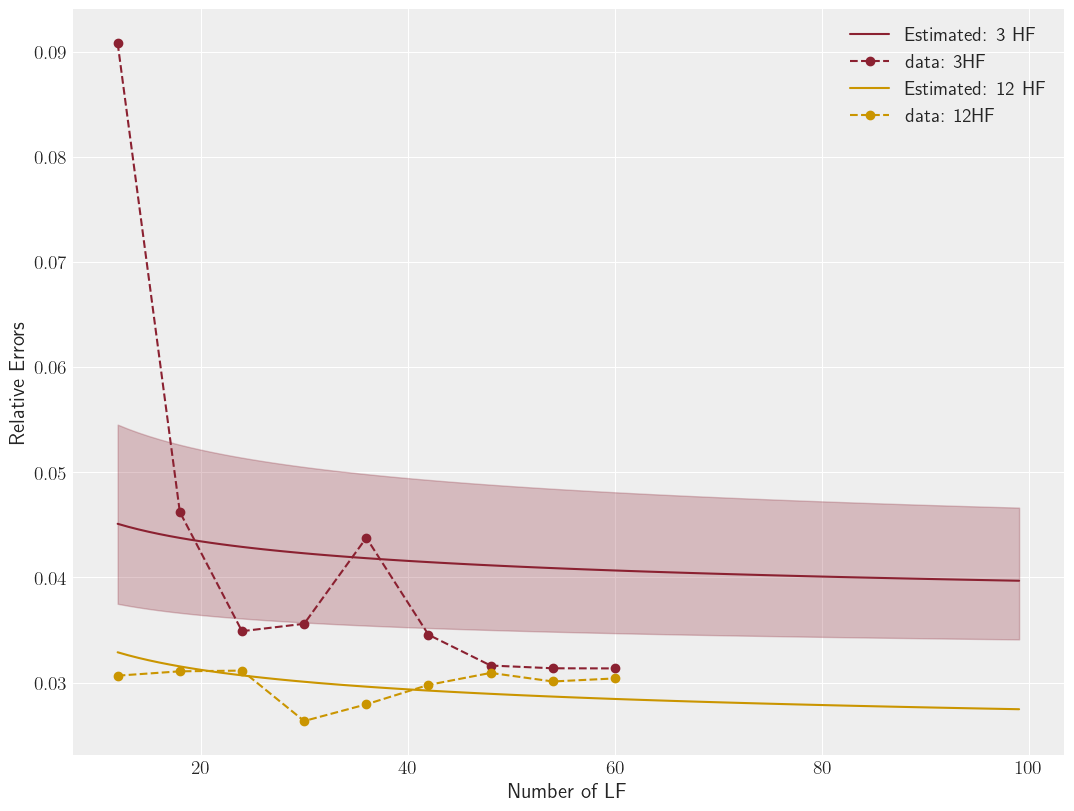

In [18]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

all_n_lfs = np.arange(12, 100)

ind = x_train[:, 1] == 3
data_lf    = x_train[ind, 0]
data_error = y_train[ind, 0]

plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, 3, theta_mode, rho_mode, nu_mode), label="Estimated: 3 HF", color=colors[0])
plt.fill_between(
    all_n_lfs,
    y1=budget_size_fn(all_n_lfs, 3, theta_lower, rho_lower, nu_upper),
    y2=budget_size_fn(all_n_lfs, 3, theta_upper, rho_upper, nu_lower),
#     label="3 HF: ",
    color=colors[0],
    alpha=0.25
)
plt.plot(data_lf, data_error, label="data: 3HF", ls="--", marker="o", color=colors[0])


###################################


ind = x_train[:, 1] == 12
data_lf    = x_train[ind, 0]
data_error = y_train[ind, 0]

plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, 12, theta_mode, rho_mode, nu_mode), label="Estimated: 12 HF", color=colors[1])
plt.plot(data_lf, data_error, label="data: 12HF", ls="--", marker="o", color=colors[1])


plt.xlabel("Number of LF")
plt.ylabel("Relative Errors")
plt.legend()
# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_inferred_LR_error.pdf", bbox_inches='tight', pad_inches=0.075)



Text(0, 0.5, 'Relative Errors')

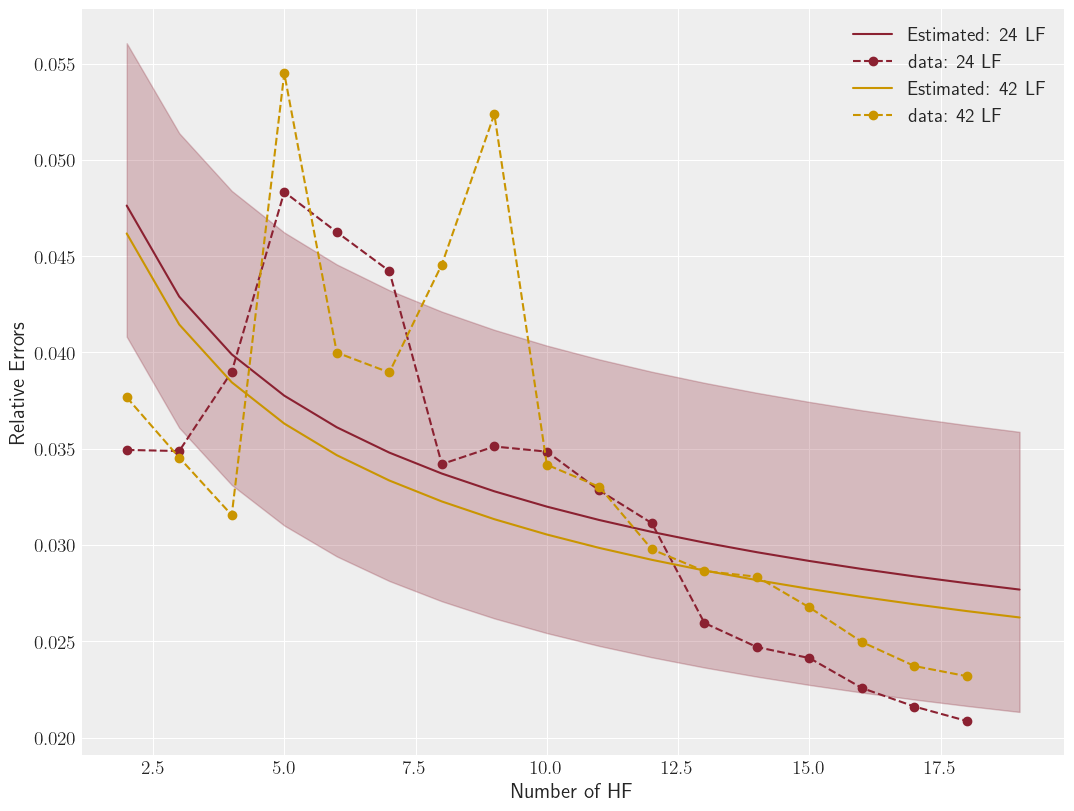

In [19]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

all_n_hfs = np.arange(2, 20)

num_lf = 24

ind = x_train[:, 0] == num_lf
data_hf    = x_train[ind, 1]
data_error = y_train[ind, 0]
data_stds  = y_sigma[ind, 0]

plt.plot(all_n_hfs, budget_size_fn(num_lf, all_n_hfs, theta_mode, rho_mode, nu_mode), label="Estimated: {} LF".format(num_lf), color=colors[0])

plt.fill_between(
    all_n_hfs,
    y1=budget_size_fn(num_lf, all_n_hfs, theta_lower, rho_lower, nu_upper),
    y2=budget_size_fn(num_lf, all_n_hfs, theta_upper, rho_upper, nu_lower),    
#     label="60 LF",
    alpha=0.25,
    color=colors[0]
)

plt.plot(data_hf, data_error, label="data: {} LF".format(num_lf), marker="o", ls="--", color=colors[0])

##########################################

num_lf = 42

ind = x_train[:, 0] == num_lf
data_hf    = x_train[ind, 1]
data_error = y_train[ind, 0]
data_stds  = y_sigma[ind, 0]

plt.plot(all_n_hfs, budget_size_fn(num_lf, all_n_hfs, theta_mode, rho_mode, nu_mode), label="Estimated: {} LF".format(num_lf), color=colors[1])

plt.plot(data_hf, data_error, label="data: {} LF".format(num_lf), marker="o", ls="--", color=colors[1])

plt.legend()

plt.xlabel("Number of HF")
plt.ylabel("Relative Errors")

# fig.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_inferred_HR_error.pdf", bbox_inches='tight', pad_inches=0.075)



In [20]:
n_estimated = lambda cost, rho, nu : (rho / cost) ** (5 / (5 + nu))

size_lf = n_estimated(1, rho_mode, nu_mode)
size_hf = n_estimated(64, 1, nu_mode)

size_lf / size_hf 

13.891328308617803

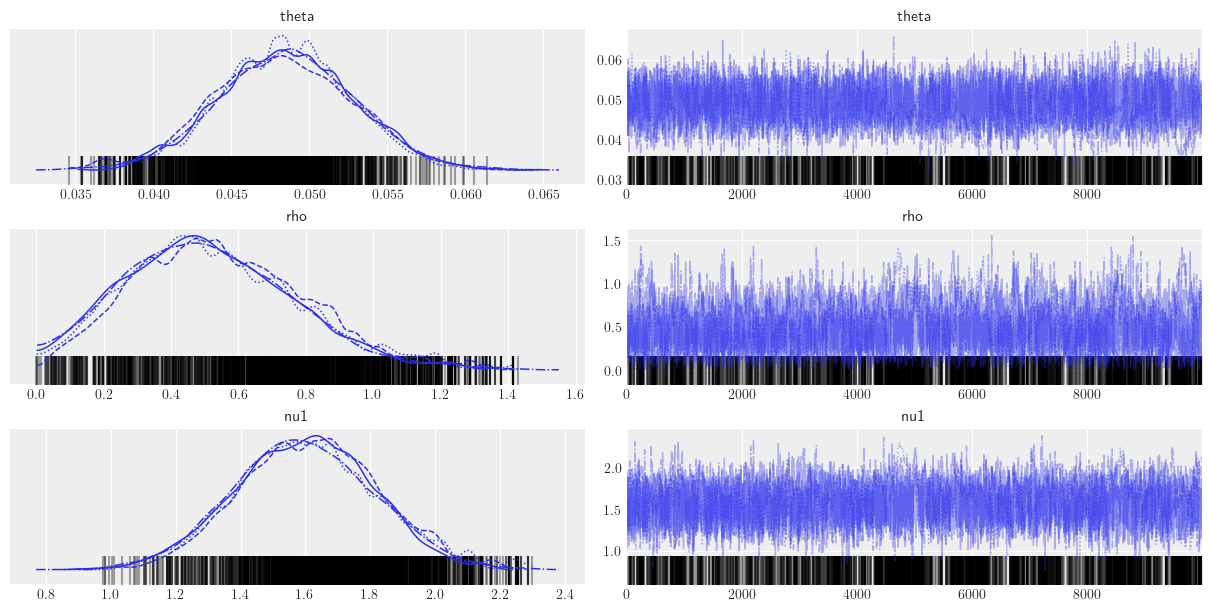

In [8]:
# plotting setting to make the arviz plots look less buggy
az.style.use("arviz-darkgrid")

with budget_model:
    rvs = ["theta", "rho", "nu1", ]

    _ = az.plot_trace(trace, var_names=rvs)
    
# plt.savefig("/home/jibancat/Documents/Latex/mf_boxsize_paper/images/budget_mcmc_chains.pdf", bbox_inches='tight', pad_inches=0.075)


# 

In [21]:
add_lf_list = [70, 80, 90, 100, 150, 200, 250, 300, 360]
file_list = [
    "../data/output/Matterpower_70_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",    
    "../data/output/Matterpower_80_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_90_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",    
    "../data/output/Matterpower_100_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_150_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_200_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_250_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_300_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",
    "../data/output/Matterpower_360_res128box256_7_res512box256_z0_ind-0-1-2-3-57-58-59/AR1/pred_exacts",    
]
errors = [
    np.mean(np.abs(np.loadtxt(f) - 1), axis=0).max() for f in file_list
]

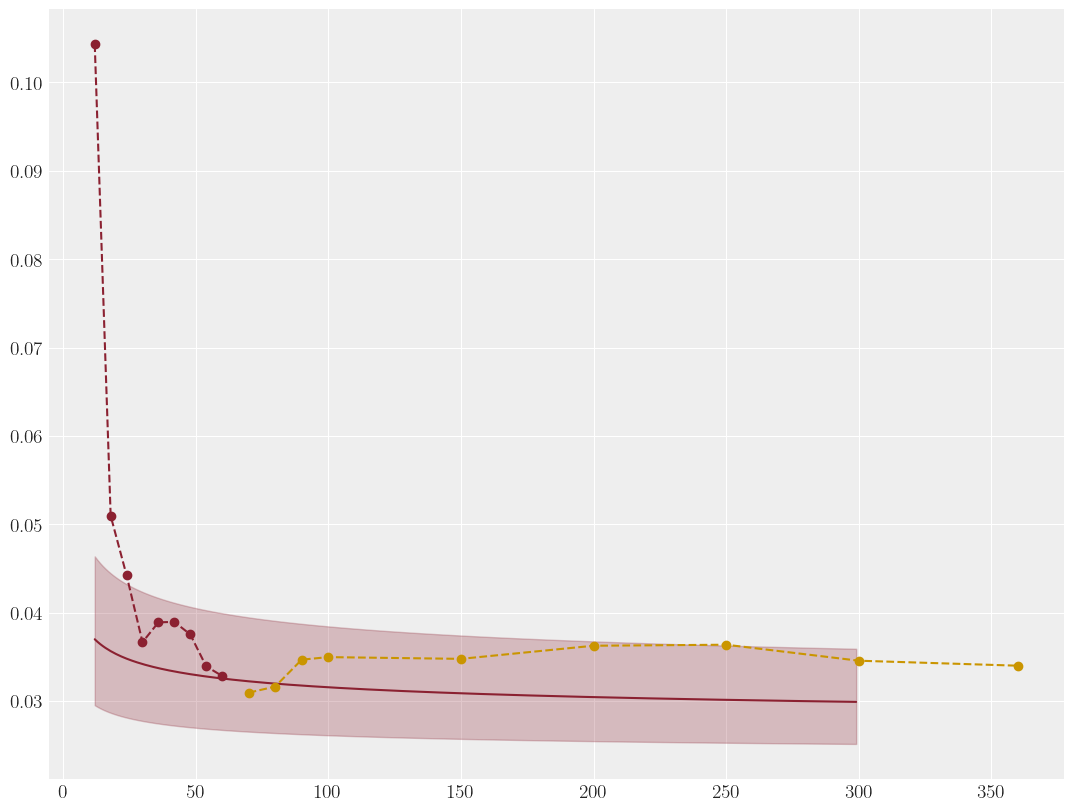

In [22]:
fig, ax = plt.subplots(figsize=(10.625, 8), nrows=1, ncols=1)

all_n_lfs = np.arange(12, 300)

num_lf = 7

ind = x_train[:, 1] == num_lf
data_lf    = x_train[ind, 0]
data_error = y_train[ind, 0]

plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, num_lf, theta_mode, rho_mode, nu_mode), label="Estimated: 3 HF", color=colors[0])
plt.fill_between(
    all_n_lfs,
    y1=budget_size_fn(all_n_lfs, num_lf, theta_lower, rho_lower, nu_upper),
    y2=budget_size_fn(all_n_lfs, num_lf, theta_upper, rho_upper, nu_lower),
    label="{} HF: ".format(num_lf),
    color=colors[0],
    alpha=0.25
)
plt.plot(data_lf, data_error, label="data: {}HF".format(num_lf), ls="--", marker="o", color=colors[0])
plt.plot(add_lf_list, errors, label="added", ls="--", marker="o", color=colors[1])
